In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [75]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)


Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [9]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.381363
sanity check: 2.302585


In [5]:
W = np.random.randn(3073, 10) * 0.0001
scores=X_dev[0] @ W
scores[y_dev[0]]

0.18743821065792532

**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [21]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.097503 analytic: 2.097503, relative error: 3.141391e-08
numerical: 2.169090 analytic: 2.169090, relative error: 7.019784e-09
numerical: -1.377904 analytic: -1.377904, relative error: 2.616910e-09
numerical: -0.514241 analytic: -0.514241, relative error: 6.912091e-09
numerical: -1.279530 analytic: -1.279530, relative error: 1.467110e-08
numerical: -0.399606 analytic: -0.399606, relative error: 5.802666e-08
numerical: -2.217533 analytic: -2.217533, relative error: 2.093061e-09
numerical: 2.199850 analytic: 2.199849, relative error: 3.323385e-08
numerical: 0.900305 analytic: 0.900305, relative error: 3.362523e-08
numerical: -1.597099 analytic: -1.597099, relative error: 1.799011e-08
numerical: -0.350229 analytic: -0.350229, relative error: 3.577847e-08
numerical: 2.258399 analytic: 2.258399, relative error: 3.016623e-08
numerical: -0.744286 analytic: -0.744286, relative error: 8.171014e-09
numerical: 0.923731 analytic: 0.923731, relative error: 1.582817e-08
numerical: -1.8273

In [20]:
loss, grad = softmax_loss_naive(W, X_dev[0:1], y_dev[0:1], 0.0)
grad[0]

array([ 0.34467387,  0.18669588,  0.26041103, -2.83168227,  0.21842109,
        0.25049197,  0.30861692,  0.37835187,  0.36534927,  0.51867037])

In [19]:
from cs231n.gradient_check import eval_numerical_gradient
f = lambda w: softmax_loss_naive(w, X_dev[0:1], y_dev[0:1], 5e1)[0]
grad = eval_numerical_gradient(f, W, verbose=False)
grad[0]

array([ 0.34068885,  0.19024106,  0.2616397 , -2.83494208,  0.21796227,
        0.23399046,  0.29549193,  0.37041592,  0.35468758,  0.5203197 ])

In [67]:
from cs231n.classifiers.softmax import softmax_loss_vectorized

X = X_dev[0:5]
y = y_dev[0:5]
scores = X @ W
correct_scores = scores[range(5),y].reshape(5,1)
exp_correct_scores = np.exp(correct_scores)
exp_scores = np.exp(scores)
sumexp = np.sum(exp_scores,axis=1)

m = np.zeros((5,10))
m[range(5),y]=1


g = ((exp_scores / sumexp.reshape(5,1) - m ).T @ X).T / 5


_,grad = softmax_loss_naive(W,X,y,0)
g[0],grad[0]


(array([ 8.92121628, 16.88363941, -4.66660122, -7.08153912, -7.25691713,
        -4.01423101, -6.57426424, -5.37400086, -4.78268857, 13.94538646]),
 array([ 8.92121628, 16.88363941, -4.66660122, -7.08153912, -7.25691713,
        -4.01423101, -6.57426424, -5.37400086, -4.78268857, 13.94538646]))

In [68]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.381363e+00 computed in 0.105804s
vectorized loss: 2.381363e+00 computed in 0.001964s
Loss difference: 0.000000
Gradient difference: 0.000000


In [71]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
#learning_rates = [1e-7, 5e-7]
learning_rates = [1e-6, 5e-6]
#regularization_strengths = [2.5e4, 5e4]
regularization_strengths = [1e4, 1e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"**** lr={lr}, reg={reg}")
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        print(f"   train_acc={train_acc}, val_acc={val_acc}")
        results[(lr,reg)] = train_acc,val_acc
        if val_acc > best_val :
            best_val = val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

**** lr=1e-06, reg=10000.0
   train_acc=0.34808163265306125, val_acc=0.364
**** lr=1e-06, reg=100000.0
   train_acc=0.26712244897959186, val_acc=0.283
**** lr=5e-06, reg=10000.0
   train_acc=0.2826530612244898, val_acc=0.276
**** lr=5e-06, reg=100000.0
   train_acc=0.0799591836734694, val_acc=0.057
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.348082 val accuracy: 0.364000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.267122 val accuracy: 0.283000
lr 5.000000e-06 reg 1.000000e+04 train accuracy: 0.282653 val accuracy: 0.276000
lr 5.000000e-06 reg 1.000000e+05 train accuracy: 0.079959 val accuracy: 0.057000
best validation accuracy achieved during cross-validation: 0.364000


In [72]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


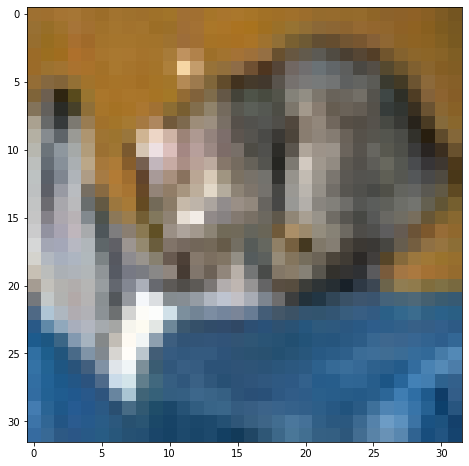

In [83]:
plt.imshow((X_test[0][:3072] +mean_image).reshape(32,32,3).astype('uint8'))
#plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))

frog frog


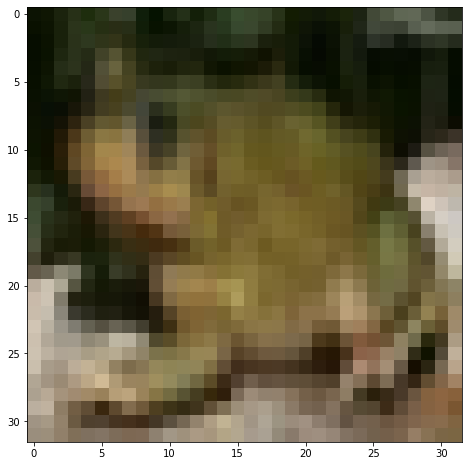

In [113]:
idx = 333
y_pred = best_softmax.predict(X_test[idx:idx+1])[0]
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classes[y_pred], classes[y_test[idx]])
plt.imshow((X_test[idx][:3072] +mean_image).reshape(32,32,3).astype('uint8'))


In [157]:
X_test[333] @ best_softmax.W

array([-1.35344652, -0.10441677,  0.36907147,  0.30744667,  1.05964544,
        0.3085873 ,  1.4057988 ,  0.65972732, -1.39767428, -1.25473943])

<BarContainer object of 10 artists>

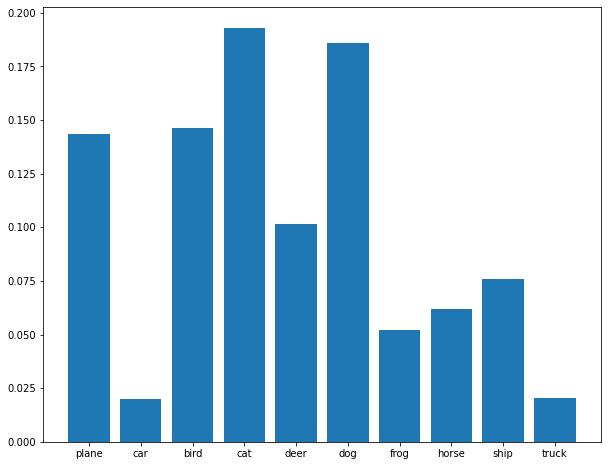

In [168]:
idx = 111
scores = X_test[idx] @ best_softmax.W
exp_scores = np.exp(scores)
sumexp = np.sum(exp_scores)
probs = exp_scores / sumexp
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.bar(classes, probs)


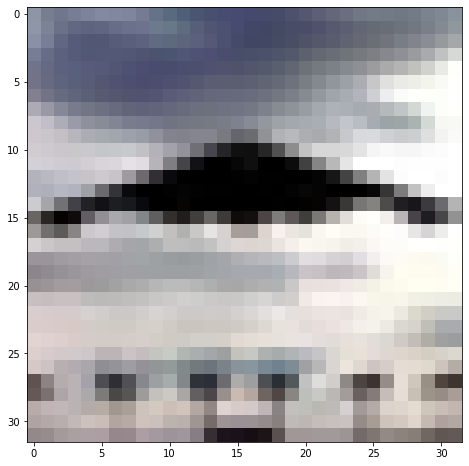

In [169]:
plt.imshow((X_test[idx][:3072] +mean_image).reshape(32,32,3).astype('uint8'))


In [152]:
#y_pred = best_softmax.predict(X_test)
#np.mean(y_pred == y_test)
#for c in range(10):
#cat_idx = np.array([idx for idx,y in enumerate(y_test.tolist()) if y==3])
#X_test[cat_idx].shape
#np.mean(best_softmax.predict(X_test[cat_idx]) == 3)

for c in range(10):
    class_idx = np.array([idx for idx,y in enumerate(y_test.tolist()) if y==c])
    acc = np.mean(best_softmax.predict(X_test[class_idx]) == c)
    print(f"{classes[c]} - {acc}")

plane - 0.4563106796116505
car - 0.33707865168539325
bird - 0.13
cat - 0.11650485436893204
deer - 0.17777777777777778
dog - 0.27906976744186046
frog - 0.625
horse - 0.1568627450980392
ship - 0.5660377358490566
truck - 0.6330275229357798


In [148]:
for c in range(10):
    print(f"{classes[c]} - {np.sum(y_train==c)}")

plane - 4913
car - 4881
bird - 4921
cat - 4888
deer - 4922
dog - 4902
frog - 4898
horse - 4893
ship - 4887
truck - 4895


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



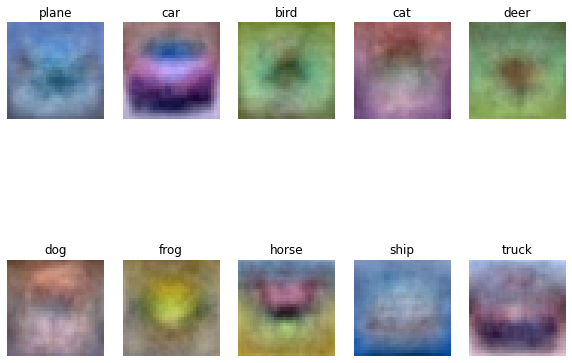

In [114]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])